In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks')

# from IPython.core.debugger import set_trace
# set_trace()

Mounted at /content/drive


In [ ]:
import tarfile
from PIL import Image

In [ ]:
pathToTar = '/content/drive/MyDrive/DataSets/mnist/mnist_png.tar.gz'

tar = tarfile.open(pathToTar, "r:gz")
tar.extractall('/content/sample_data/')

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import matplotlib.pyplot as plt

import os

import FunctionsForNets as myFunc

USE_GPU = True
dtype = torch.float32 # We will be using float throughout this tutorial.

if USE_GPU and torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

print(device)

cuda


In [ ]:
trainTransforms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010)),
])

# validTransforms = T.Compose([
#     T.ToTensor(),
#     T.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
# ])

testTransforms = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
])

In [ ]:
rootPath = '/content/sample_data/mnist_png'
trainPath = os.path.join(rootPath, 'training')
testPath = os.path.join(rootPath, 'testing')
# validPath = os.path.join(rootPath, 'ValidImages')

if not (os.path.exists(trainPath) and os.path.exists(testPath)): #and os.path.exists(validPath)):
  print('Could not find dataset')

trainSet = dset.ImageFolder(trainPath, trainTransforms)
# validSet = dset.ImageFolder(validPath, validTransforms)
testSet = dset.ImageFolder(testPath, testTransforms)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


60000
image size -  torch.Size([3, 28, 28])
Num_classes -  10


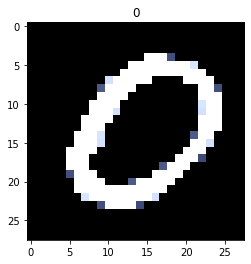

In [ ]:
x, y = trainSet[1000]
print(len(trainSet))

className = list(trainSet.class_to_idx.keys())[list(trainSet.class_to_idx.values()).index(y)] # Get name of class
plt.title(className)
plt.imshow(x.permute(1, 2, 0))
print('image size - ', x.shape)
print('Num_classes - ', len(trainSet.class_to_idx))

In [ ]:
num_samples = 60000
num_valid = 4000
num_train = num_samples - num_valid
trainLoader = DataLoader(trainSet, batch_size=16, sampler=sampler.SubsetRandomSampler(range(0, num_train)))
validLoader = DataLoader(trainSet, batch_size=16, sampler=sampler.SubsetRandomSampler(range(num_train, num_samples)))
testLoader = DataLoader(testSet, batch_size=16)

In [ ]:
class SmallConvNet(nn.Module):

    def __init__(self, image_channels, hidden_channels, num_classes):

        super().__init__()

        self.conv1 = nn.Conv2d(image_channels, hidden_channels[0], kernel_size = 3, stride = 1, padding = 1)
        self.conv2 = nn.Conv2d(hidden_channels[0], hidden_channels[1], kernel_size = 3, stride = 1, padding = 1)
        self.conv3 = nn.Conv2d(hidden_channels[1], hidden_channels[2], kernel_size = 3, stride = 1, padding = 1)

        self.bn1 = nn.BatchNorm2d(hidden_channels[0])
        self.bn2 = nn.BatchNorm2d(hidden_channels[1])
        self.bn3 = nn.BatchNorm2d(hidden_channels[2])

        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(7 * 7 * hidden_channels[2], 100)
        self.fc2 = nn.Linear(100, num_classes)
        self.drop = nn.Dropout(p = 0.5)

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.pool(x)

        x = x.reshape(x.shape[0], -1)
        x = self.fc1(x)
        x = self.drop(x)
        x = self.fc2(x)

        return x

        

In [ ]:
model = SmallConvNet(3, [64, 128, 256], 10)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
myFunc.train_model(model, optimizer, trainLoader, validLoader, num_epoch=2, device=device, printAndSaveEvery=100, savePath='/content/drive/MyDrive/MnistModels')

Starting new training
Start 0 epoch
Iteration 100:
Got 1444 / 1616 correct (89.36) in train
Got 1663 / 4000 correct (41.58) in validation
Goten new best val accuracy. Save new best model
Iteration 200:
Got 1531 / 1616 correct (94.74) in train
Got 2774 / 4000 correct (69.35) in validation
Goten new best val accuracy. Save new best model
Iteration 300:
Got 1541 / 1616 correct (95.36) in train
Got 2903 / 4000 correct (72.58) in validation
Goten new best val accuracy. Save new best model
Iteration 400:
Got 1557 / 1616 correct (96.35) in train
Got 3620 / 4000 correct (90.50) in validation
Goten new best val accuracy. Save new best model
Iteration 500:
Got 1573 / 1616 correct (97.34) in train
Got 3697 / 4000 correct (92.42) in validation
Goten new best val accuracy. Save new best model
Iteration 600:
Got 1566 / 1616 correct (96.91) in train
Got 3312 / 4000 correct (82.80) in validation
Iteration 700:
Got 1568 / 1616 correct (97.03) in train
Got 3600 / 4000 correct (90.00) in validation
Itera

KeyboardInterrupt: ignored

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/MnistModels/best_model.pt')

model.load_state_dict(checkpoint['Model_state_dict'])

optimizer = optim.SGD(model.parameters(), lr=0.00001, momentum=0.9)

optimizer.load_state_dict(checkpoint['Optimizer_state_dict'])

contTrain = {
    'train_accs': checkpoint['Train_accs'],
    'val_accs': checkpoint['Val_accs'],
    'num_ep': checkpoint['Num_epoch']
}
train_acc, val_acc = myFunc.train_model(model, optimizer, trainLoader, validLoader, 2, device, 
                                        printAndSaveEvery=100, savePath='/content/drive/MyDrive/MnistModels', continueTraining=contTrain)

Continue training from 1 epoch
Start 1 epoch
Iteration 100:
Got 1575 / 1616 correct (97.46) in train
Got 3787 / 4000 correct (94.67) in validation
Iteration 200:
Got 1576 / 1616 correct (97.52) in train
Got 3733 / 4000 correct (93.33) in validation
Iteration 300:
Got 1583 / 1616 correct (97.96) in train
Got 3766 / 4000 correct (94.15) in validation
Iteration 400:
Got 1583 / 1616 correct (97.96) in train
Got 3743 / 4000 correct (93.58) in validation
Iteration 500:
Got 1569 / 1616 correct (97.09) in train
Got 3845 / 4000 correct (96.12) in validation
Iteration 600:
Got 1578 / 1616 correct (97.65) in train
Got 3830 / 4000 correct (95.75) in validation
Iteration 700:
Got 1578 / 1616 correct (97.65) in train
Got 3792 / 4000 correct (94.80) in validation
Iteration 800:
Got 1567 / 1616 correct (96.97) in train
Got 3738 / 4000 correct (93.45) in validation
Iteration 900:
Got 1574 / 1616 correct (97.40) in train
Got 3822 / 4000 correct (95.55) in validation
Iteration 1000:
Got 1595 / 1616 corre

In [ ]:
def get_wrong_classificated(model, dataLoader):
  """
  Get images that net classificated wrong
  """
  cpu_device=torch.device('cpu')

  model = model.to(device=cpu_device)

  wrongSamples = []

  model.eval()

  with torch.no_grad():
    for i, (x, y) in enumerate(dataLoader):
      x = x.to(device=cpu_device, dtype=torch.float32)
      y = y.to(device=cpu_device, dtype=torch.long)

      scores = model(x)
      _, preds = scores.max(1)

      indexes_wrong = np.argwhere(preds.numpy() != y.numpy())
      for j in indexes_wrong:
          # from IPython.core.debugger import set_trace
          # set_trace()
          wrongSamples.append((x[j[0]], y[j[0]]))

    print('Got %d wrong answers'% (len(wrongSamples)))
    return wrongSamples


In [ ]:
wrong_samples = get_wrong_classificated(model, testLoader)

Got 230 wrong answers


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


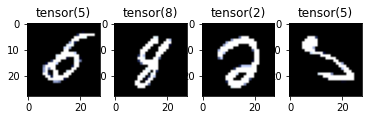

In [ ]:
for i in range(4):
    plt.subplot(1, 4, i+1)

    randIndex = random.randint(1, len(wrong_samples))
    plt.imshow(wrong_samples[randIndex][0].permute(1, 2, 0))
    plt.title(wrong_samples[randIndex][1])

In [ ]:
#Checking scripts
import zipfile

pathToZip = '/content/drive/MyDrive/TestMnist.zip'

z = zipfile.ZipFile(pathToZip, 'r')
z.extractall('/content/sample_data/')

In [10]:
%load_ext autoreload
%autoreload 2

In [12]:
%cd /content/sample_data
!python3 mnist.py --mode train --model MnistModel.pt --dataset train.csv
!python3 mnist.py --mode inference --model MnistModel.pt --input test.csv --output out.csv
!python3 evaluate.py --ground_truth test.csv --predictions out.csv


/content/sample_data
Using cuda for model computations
Starting training
Start 0 epoch
Iteration 200:
Got 4953 / 5616 correct (0.882) in train
Got 223 / 4000 correct (0.056) in validation
Goten new best val accuracy. Save new best model
Iteration 400:
Got 5226 / 5616 correct (0.931) in train
Got 3038 / 4000 correct (0.760) in validation
Goten new best val accuracy. Save new best model
Iteration 600:
Got 5315 / 5616 correct (0.946) in train
Got 3213 / 4000 correct (0.803) in validation
Goten new best val accuracy. Save new best model
Iteration 800:
Got 5348 / 5616 correct (0.952) in train
Got 3482 / 4000 correct (0.871) in validation
Goten new best val accuracy. Save new best model
Iteration 1000:
Got 5346 / 5616 correct (0.952) in train
Got 3332 / 4000 correct (0.833) in validation
Iteration 1200:
Got 5404 / 5616 correct (0.962) in train
Got 3488 / 4000 correct (0.872) in validation
Goten new best val accuracy. Save new best model
Iteration 1400:
Got 5424 / 5616 correct (0.966) in trai